In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [ ]:
# Load data
def load_data():
    forwards = pd.read_csv('Forwards.csv')
    midfielders = pd.read_csv('Midfielders.csv')
    defenders = pd.read_csv('Defenders.csv')
    goalkeepers = pd.read_csv('Goalkeepers.csv')
    return forwards, midfielders, defenders, goalkeepers

In [ ]:
# Preprocess data
def preprocess_data(df):
    return df.fillna(0)

def select_features(df, position):
    if position == 'Goalkeeper':
        return ['Goals Against', 'GA_p90', 'Saves', 'Save%', 'Clean Sheets', 'PK Saved', 'PSxG-GA', 'Passes>40yd %', 'Def OPA_p90', 'Crosses Stop %']
    
    common_features = ['Goals', 'Assist', 'Yellow Card', 'Red Card']
    
    if position == 'Forward':
        specific_features = ['xG', 'npxG', 'xAG', 'Shots', 'Shots on Target', 'Prog Carry', 'Prog Pass Rec', 'Penalty Kicks Scored']
    elif position == 'Midfielder':
        specific_features = ['xG', 'xAG', 'Prog Carry', 'Prog Pass', 'Prog Pass Rec', 'Pass Completed', 'Key Passes', 'Passes into Final Third', 'Passes into Penalty Area', 'GCA_p90', 'SCA_p90']
    elif position == 'Defender':
        specific_features = ['Tackles Done', 'Tackles Won', 'Blocks Total', 'Intercept', 'Clearance', 'Drib Tack Won%', 'Errors to shot', 'Prog Carry', 'Prog Pass']
    else:
        raise ValueError("Invalid position")
    
    return common_features + specific_features

In [ ]:
# Calculate similarity using cosine similarity
def calculate_cosine_similarity(df, features, player_name):
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    similarity_matrix = cosine_similarity(X_scaled)
    player_index = df[df['Player Name'] == player_name].index[0]
    similarities = similarity_matrix[player_index]
    
    return similarities

In [ ]:
# Calculate similarity using K-Nearest Neighbors
def calculate_knn_similarity(df, features, player_name, n_neighbors=6):
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
    knn.fit(X_scaled)
    
    player_index = df[df['Player Name'] == player_name].index[0]
    distances, indices = knn.kneighbors(X_scaled[player_index].reshape(1, -1))
    
    return distances.flatten(), indices.flatten()

In [ ]:
def get_recommendations(df, cosine_similarities, knn_similarities, player_name, n=5):
    cosine_similar_players = list(enumerate(cosine_similarities))
    cosine_similar_players = sorted(cosine_similar_players, key=lambda x: x[1], reverse=True)
    cosine_similar_players = cosine_similar_players[1:n+1]  # Exclude the player itself

    knn_distances, knn_indices = knn_similarities
    knn_similar_players = list(zip(knn_indices[1:], 1 / (knn_distances[1:] + 1e-6)))  # Convert distance to similarity score

    recommendations = []
    for i, score in cosine_similar_players:
        player = df.iloc[i]
        recommendations.append({
            'name': player['Player Name'],
            'age': player['Age'],
            'squad': player['Squad'],
            'cosine_score': score,
            'knn_score': next((s for j, s in knn_similar_players if j == i), 0)
        })
    
    return recommendations

In [ ]:
def recommend_players(player_name, position):
    forwards, midfielders, defenders, goalkeepers = load_data()
    
    if position == 'Forward':
        df = preprocess_data(forwards)
    elif position == 'Midfielder':
        df = preprocess_data(midfielders)
    elif position == 'Defender':
        df = preprocess_data(defenders)
    elif position == 'Goalkeeper':
        df = preprocess_data(goalkeepers)
    else:
        raise ValueError("Invalid position")
    
    if player_name not in df['Player Name'].values:
        raise ValueError(f"Player {player_name} not found in the {position}s database")
    
    features = select_features(df, position)
    
    cosine_similarities = calculate_cosine_similarity(df, features, player_name)
    knn_similarities = calculate_knn_similarity(df, features, player_name)
    
    recommendations = get_recommendations(df, cosine_similarities, knn_similarities, player_name)
    
    return recommendations, df[df['Player Name'] == player_name].iloc[0], df, features

In [ ]:
def visualize_comparison(input_player, similar_player_cosine, similar_player_knn, features):
    input_stats = input_player[features].values.flatten()
    similar_stats_cosine = similar_player_cosine[features].values.flatten()
    similar_stats_knn = similar_player_knn[features].values.flatten()
    
    angles = np.linspace(0, 2*np.pi, len(features), endpoint=False)
    
    input_stats = np.concatenate((input_stats, [input_stats[0]]))
    similar_stats_cosine = np.concatenate((similar_stats_cosine, [similar_stats_cosine[0]]))
    similar_stats_knn = np.concatenate((similar_stats_knn, [similar_stats_knn[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection='polar'))
    ax.plot(angles, input_stats, 'o-', linewidth=2, label=input_player['Player Name'])
    ax.fill(angles, input_stats, alpha=0.25)
    ax.plot(angles, similar_stats_cosine, 'o-', linewidth=2, label=f"{similar_player_cosine['Player Name']} (Cosine)")
    ax.fill(angles, similar_stats_cosine, alpha=0.25)
    ax.plot(angles, similar_stats_knn, 'o-', linewidth=2, label=f"{similar_player_knn['Player Name']} (KNN)")
    ax.fill(angles, similar_stats_knn, alpha=0.25)
    
    ax.set_thetagrids(angles[:-1] * 180/np.pi, features)
    ax.set_title(f"Player Comparison: {input_player['Player Name']} vs Most Similar Players")
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    plt.tight_layout()
    plt.show()

Welcome to the Player Recommendation System v4
Enter the player name: Marcus Rashford

Player found: Marcus Rashford
Positions: FW
Enter the position for recommendation (Forward/Midfielder/Defender/Goalkeeper): Forward

Top 5 similar players to Marcus Rashford (Forward):
1. Yukinari Sugawara (Age: 24-096, Team: Southampton, Cosine Similarity: 0.89, KNN Similarity: 0.49)
2. Miguel Gutiérrez (Age: 23-067, Team: Girona, Cosine Similarity: 0.89, KNN Similarity: 0.00)
3. Adrien Thomasson (Age: 30-297, Team: Lens, Cosine Similarity: 0.88, KNN Similarity: 0.52)
4. Jamie Leweling (Age: 23-219, Team: Stuttgart, Cosine Similarity: 0.87, KNN Similarity: 0.48)
5. Ainsley Maitland-Niles (Age: 27-034, Team: Lyon, Cosine Similarity: 0.86, KNN Similarity: 0.47)

Input player data:
Unnamed: 0                            1625
Rank                                  1626
Player Name                Marcus Rashford
Nation                             eng ENG
Position                                FW
Squad    

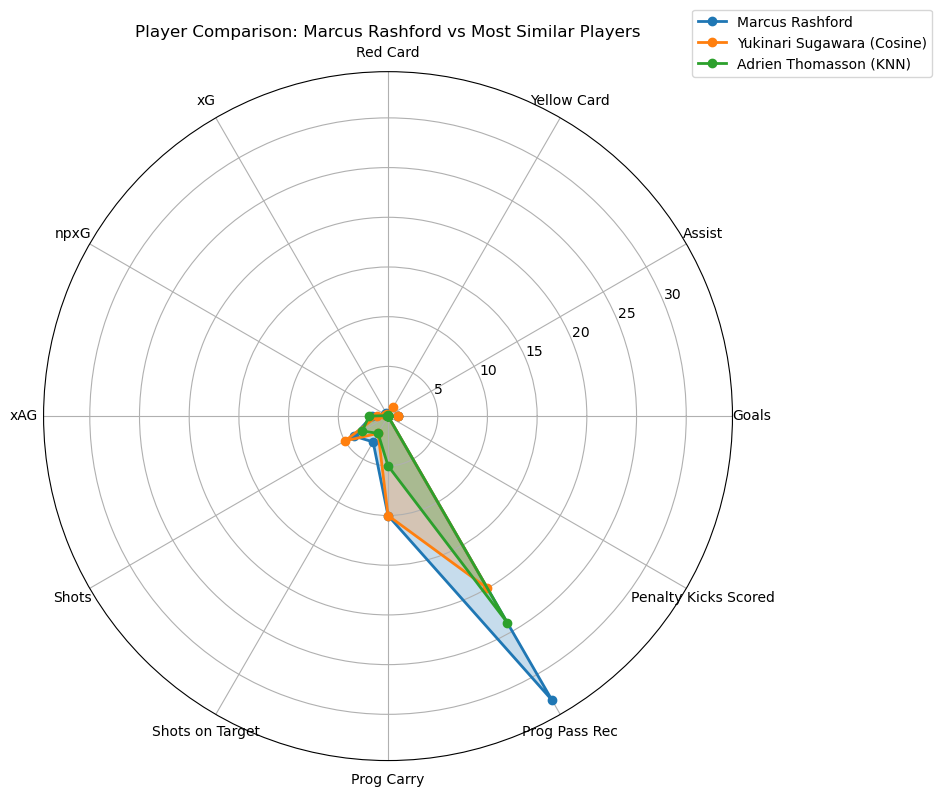

In [19]:
def cli():
    print("Welcome to the Player Recommendation System v4")
    player_name = input("Enter the player name: ")
    
    forwards, midfielders, defenders, goalkeepers = load_data()
    all_players = pd.concat([forwards, midfielders, defenders, goalkeepers])
    player_info = all_players[all_players['Player Name'] == player_name]
    
    if player_info.empty:
        print(f"Player {player_name} not found in the database")
        return
    
    print(f"\nPlayer found: {player_name}")
    print(f"Positions: {player_info['Position'].values[0]}")
    
    position = input("Enter the position for recommendation (Forward/Midfielder/Defender/Goalkeeper): ")
    
    try:
        recommendations, player_data, df, features = recommend_players(player_name, position)
        print(f"\nTop 5 similar players to {player_name} ({position}):")
        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec['name']} (Age: {rec['age']}, Team: {rec['squad']}, Cosine Similarity: {rec['cosine_score']:.2f}, KNN Similarity: {rec['knn_score']:.2f})")
        
        print("\nInput player data:")
        print(player_data)
        
        # Visualize comparison with the most similar players from both methods
        most_similar_player_cosine = df[df['Player Name'] == recommendations[0]['name']].iloc[0]
        most_similar_player_knn = df[df['Player Name'] == max(recommendations, key=lambda x: x['knn_score'])['name']].iloc[0]
        visualize_comparison(player_data, most_similar_player_cosine, most_similar_player_knn, features)
        
    except ValueError as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    cli()